**#0 Importy**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve
from numpy import where, meshgrid, arange, hstack

**#1 Wczytanie bazy i przygotowanie danych**

In [2]:
diabetes = pd.read_csv('diabetes.csv')

In [3]:
features = ['Pregnancies','PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age']
target = 'Diabetic'
X, y = diabetes[features], diabetes[target]

**#2 Podział na zbiór treningowy i testowy**

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X[['Pregnancies', 'Age']], y, test_size=0.30, random_state=0, stratify=y)

**#3 Skalowanie danych**

In [5]:
scaler_2var = StandardScaler()
X_train_standardized = scaler_2var.fit_transform(X_train)
X_test_standardized = scaler_2var.transform(X_test)

**# 4 Tworzenie DataFrame do przechowywania wyników**

In [6]:
metrics_dataframe = pd.DataFrame(columns=['Model', 'F1_score', 'AUC', 'C', 'Penalty', 'Class Weight'])

**#5 Funkcja do obliczania metryk**

In [7]:
def calculate_metrics(model, name, X_checked, y_checked, specifics):
    global metrics_dataframe
    predictions = model.predict(X_checked)
    predictions_proba = model.predict_proba(X_checked)
    
    # Wyciąganie parametrów
    c_val, penalty, class_weight = specifics

    # Metryki i raport
    print(f"Metryki dla modelu {name} (C={c_val}, Penalty={penalty}, Class Weight={class_weight}):")
    print(classification_report(y_checked, predictions))
    
    # Macierz omyłek
    cm = confusion_matrix(y_checked, predictions)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.show()
    
    # Krzywa ROC
    fpr, tpr, thresholds = roc_curve(y_checked, predictions_proba[:, 1])
    auc = roc_auc_score(y_checked, predictions_proba[:, 1])
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve (C={c_val}, Penalty={penalty})')
    plt.legend()
    plt.show()
    
    # Zapisanie metryk
    f1_metric = f1_score(y_checked, predictions)
    new_row = pd.DataFrame({'Model': [name], 'F1_score': [f1_metric], 'AUC': [auc],
                            'C': [c_val], 'Penalty': [penalty], 
                            'Class Weight': [class_weight]})
    metrics_dataframe = pd.concat([metrics_dataframe, new_row], ignore_index=True)

**#6 Funkcja do wizualizacji powierzchni klasyfikacji**

In [8]:
def plot_classification_surface(X_plot, y_plot, trained_model, specifics):
    plt.figure(figsize=(12, 7))

    # Wyciąganie parametrów
    c_val, penalty, _ = specifics

    # określenie granic zbioru
    min1, max1 = X_plot[:, 0].min()-1, X_plot[:, 0].max()+1
    min2, max2 = X_plot[:, 1].min()-1, X_plot[:, 1].max()+1

    # skalowanie dla obu osi
    x1grid = arange(min1, max1, 0.1)
    x2grid = arange(min2, max2, 0.1)

    # utworzenie siatki
    xx, yy = meshgrid(x1grid, x2grid)

    # przetworzenie siatki w wektor
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

    # stworzenie zmiennych objaśniających dla modelu
    grid = hstack((r1,r2))

    # predykcja modelu zbioru
    yhat = trained_model.predict(grid)

    # przetworzenie predykcji na decyzji dla konkretnego punktu wykresu
    zz = yhat.reshape(xx.shape)

    # wizualizacja siatki z przyporządkowaną klasą
    plt.contourf(xx, yy, zz, cmap='Paired', alpha=0.6)

    # tworzenie wykresu punktowego dla klas ze zbioru X
    for class_value in range(2):

        # przyporządkowanie klasy (y) do obsewacji (X)
        row_ix = where(y_plot == class_value)

        # stworzenie wykresu punktowego
        plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], c=['red', 'blue'][class_value],
                    alpha=0.8, label=f"Class {class_value}")

    # wizualizacja wykresu
    plt.legend(loc='upper right')
    plt.title(f"Classification Surface (C={c_val}, Penalty={penalty})")
    plt.xlabel("Feature 1 (Standardized)")
    plt.ylabel("Feature 2 (Standardized)")
    plt.show()

**#7 Ustawienia parametrów i tworzenie modeli**

In [9]:
C_values = [0.01, 0.1, 1, 10, 100]
penalties = ['l1', 'l2']
class_weights = ['balanced', None]
our_models = []

# Tworzenie i testowanie modeli
for C in C_values:
    for penalty in penalties:
        for class_weight in class_weights:
            solver = 'liblinear' if penalty == 'l1' else 'lbfgs'
            try:
                model = LogisticRegression(C=C, penalty=penalty, class_weight=class_weight,
                                            solver=solver, max_iter=1000)
                model.fit(X_train_standardized, y_train)
                specifics = [C, penalty, class_weight]
                our_models.append([model, specifics])
            except ValueError as e:
                print(f"Nie można utworzyć modelu z parametrami: C={C}, penalty={penalty}, "
                      f"class_weight={class_weight}. Błąd: {e}")

**#8 Ocena modeli i wizualizacja wyników**

Metryki dla modelu Logistic Regression (C=0.01, Penalty=l1, Class Weight=balanced):
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      3000
           1       0.55      0.71      0.62      1500

    accuracy                           0.71      4500
   macro avg       0.69      0.71      0.69      4500
weighted avg       0.74      0.71      0.71      4500



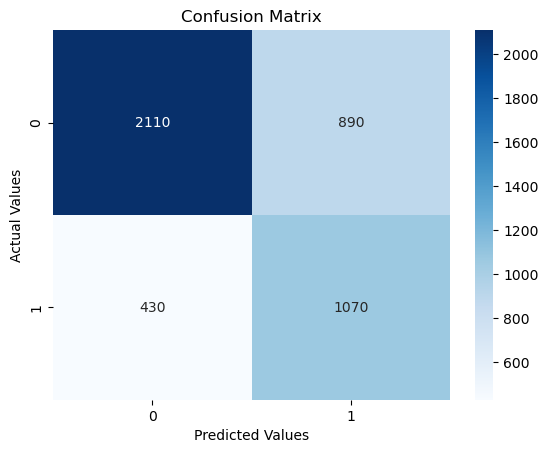

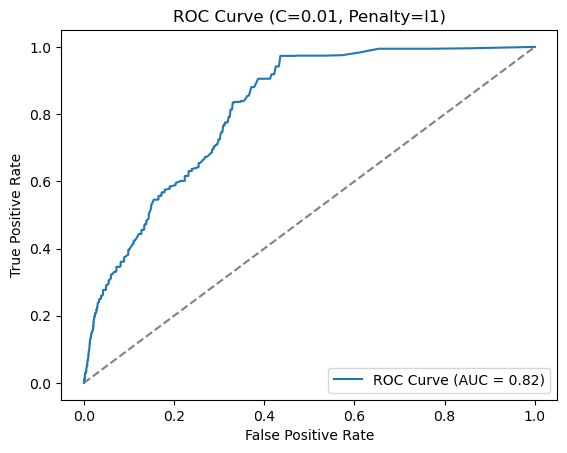

C:\Users\Mateusz\AppData\Local\Temp\ipykernel_8520\2234606764.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_dataframe = pd.concat([metrics_dataframe, new_row], ignore_index=True)


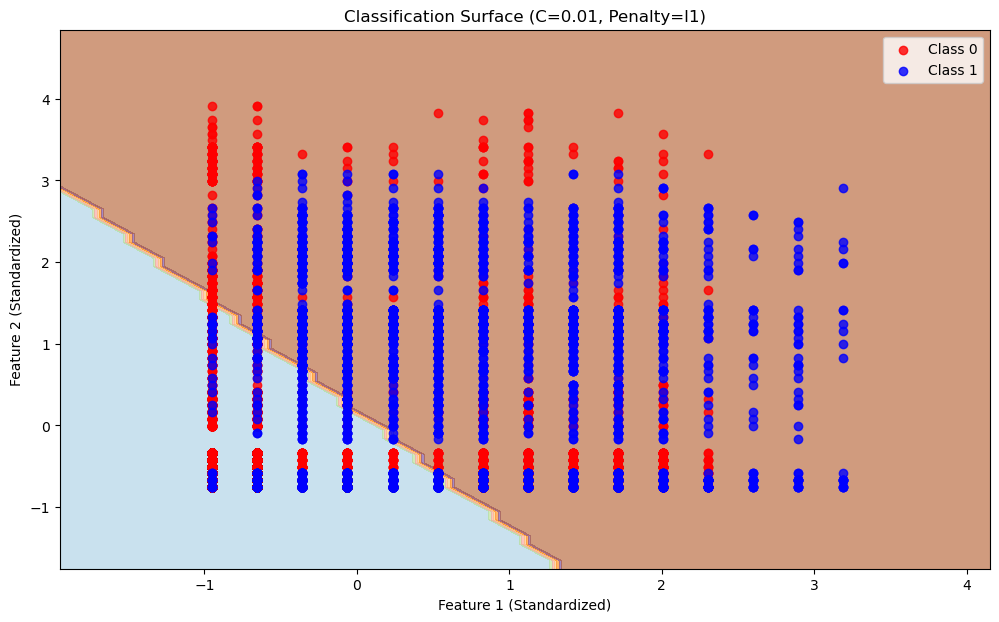

Metryki dla modelu Logistic Regression (C=0.01, Penalty=l1, Class Weight=None):
              precision    recall  f1-score   support

           0       0.78      0.85      0.82      3000
           1       0.64      0.53      0.58      1500

    accuracy                           0.74      4500
   macro avg       0.71      0.69      0.70      4500
weighted avg       0.74      0.74      0.74      4500



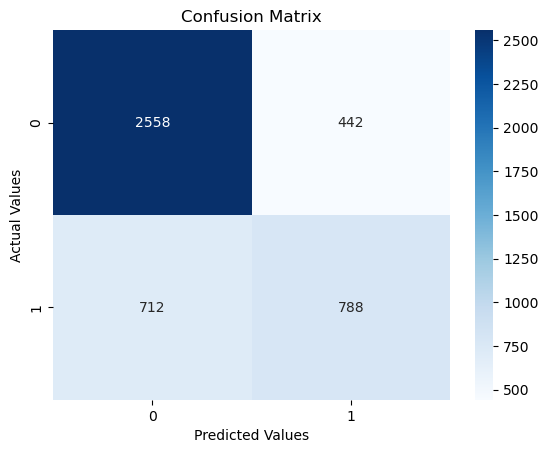

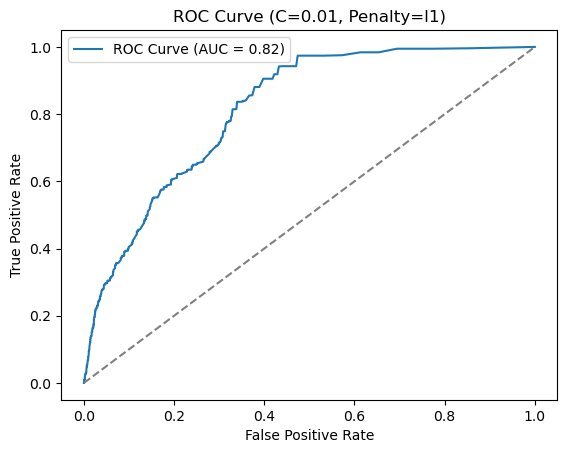

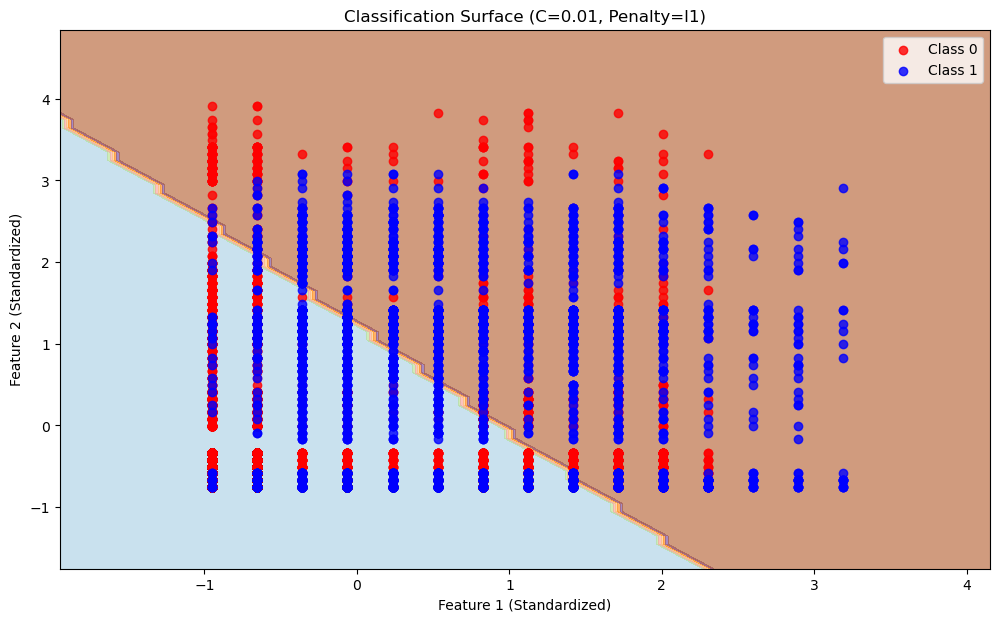

Metryki dla modelu Logistic Regression (C=0.01, Penalty=l2, Class Weight=balanced):
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      3000
           1       0.55      0.71      0.62      1500

    accuracy                           0.71      4500
   macro avg       0.69      0.71      0.69      4500
weighted avg       0.73      0.71      0.71      4500



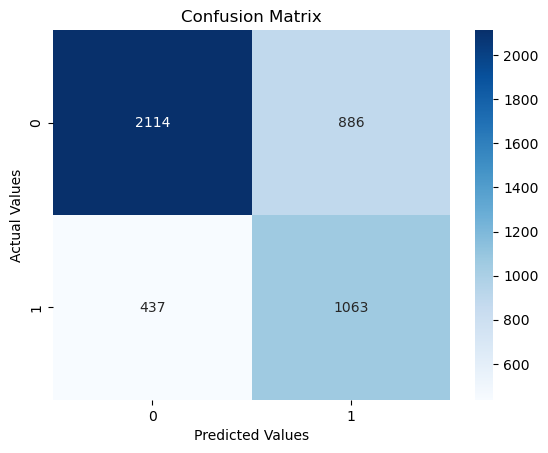

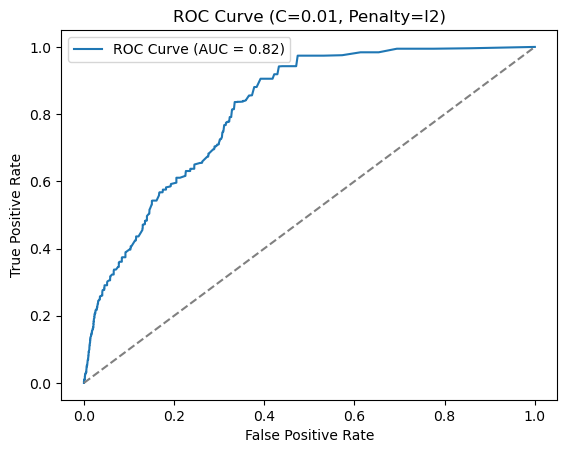

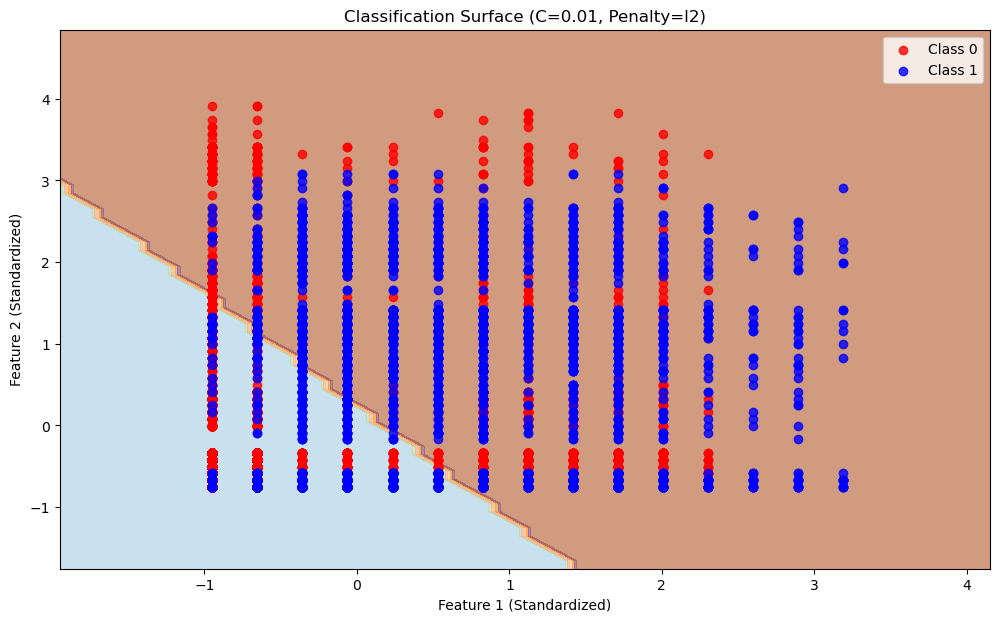

Metryki dla modelu Logistic Regression (C=0.01, Penalty=l2, Class Weight=None):
              precision    recall  f1-score   support

           0       0.78      0.86      0.82      3000
           1       0.64      0.51      0.57      1500

    accuracy                           0.74      4500
   macro avg       0.71      0.68      0.69      4500
weighted avg       0.73      0.74      0.73      4500



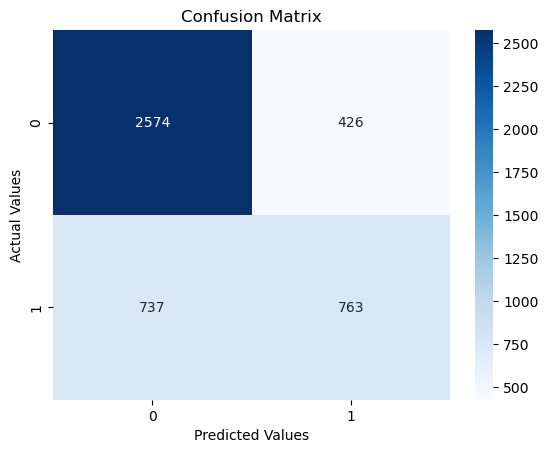

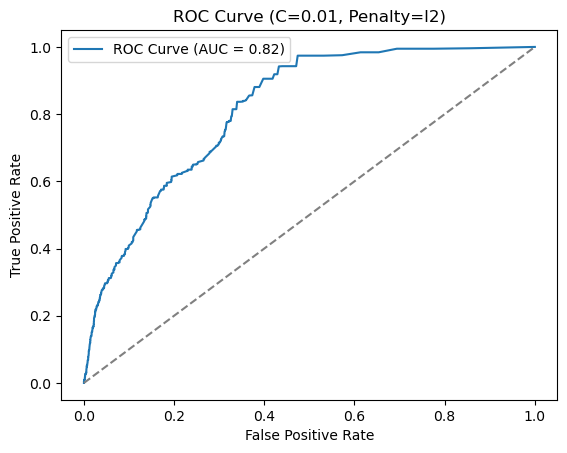

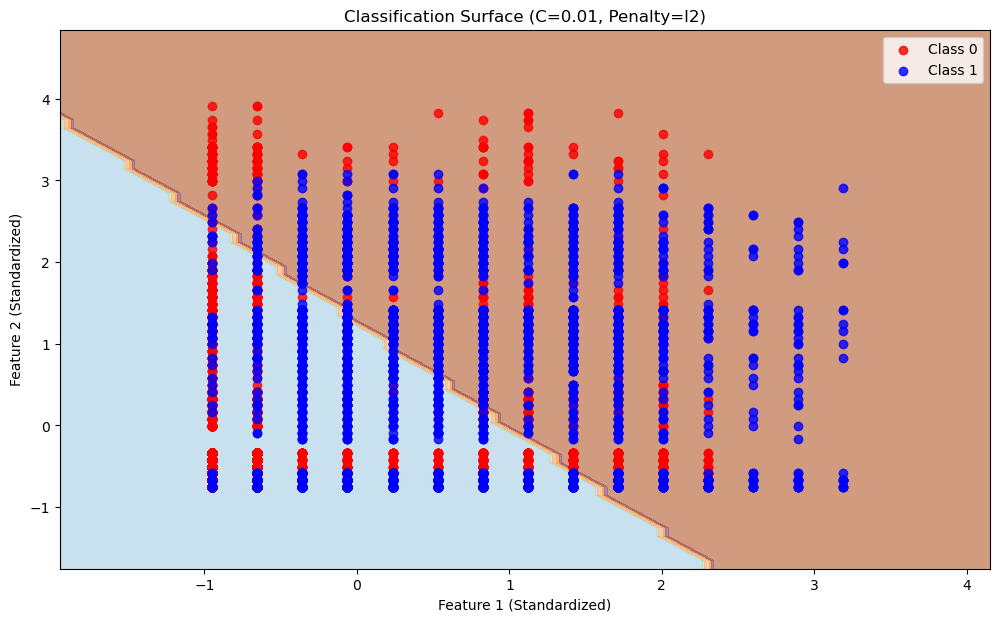

Metryki dla modelu Logistic Regression (C=0.1, Penalty=l1, Class Weight=balanced):
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      3000
           1       0.55      0.71      0.62      1500

    accuracy                           0.71      4500
   macro avg       0.69      0.71      0.69      4500
weighted avg       0.73      0.71      0.71      4500



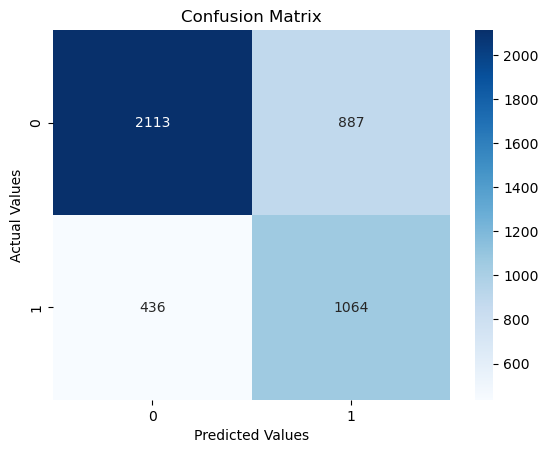

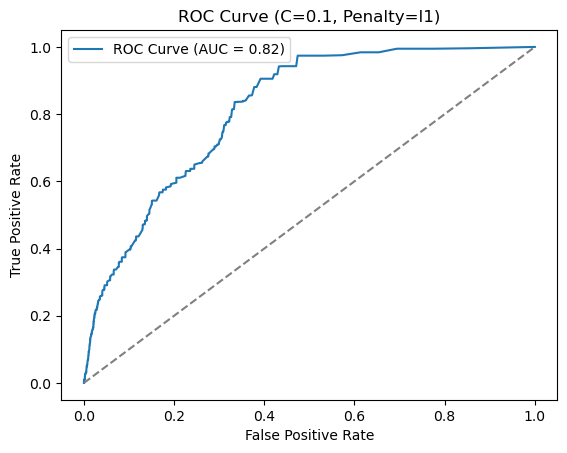

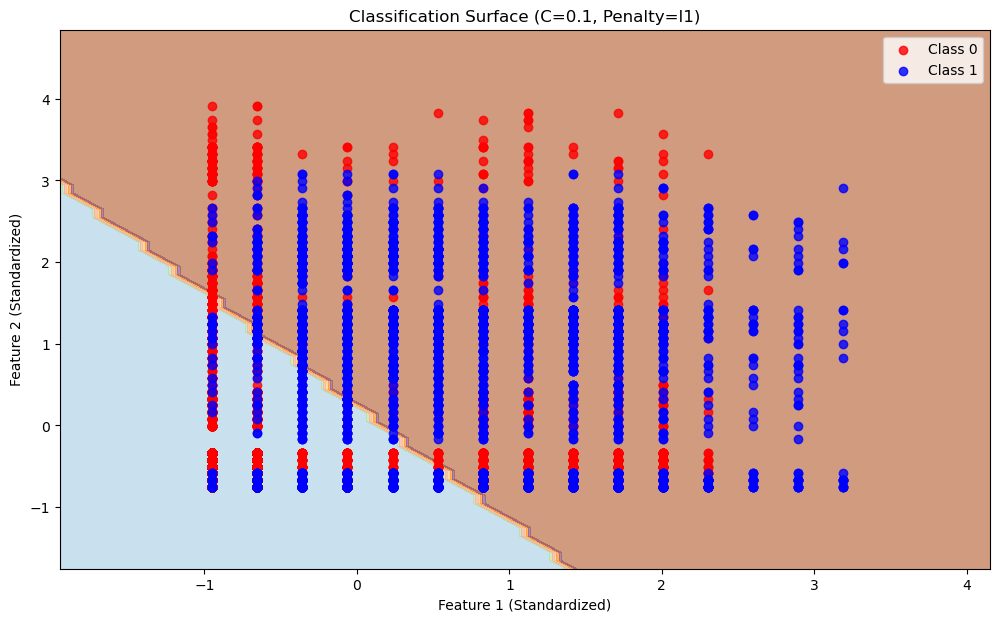

Metryki dla modelu Logistic Regression (C=0.1, Penalty=l1, Class Weight=None):
              precision    recall  f1-score   support

           0       0.78      0.85      0.82      3000
           1       0.64      0.53      0.58      1500

    accuracy                           0.75      4500
   macro avg       0.71      0.69      0.70      4500
weighted avg       0.74      0.75      0.74      4500



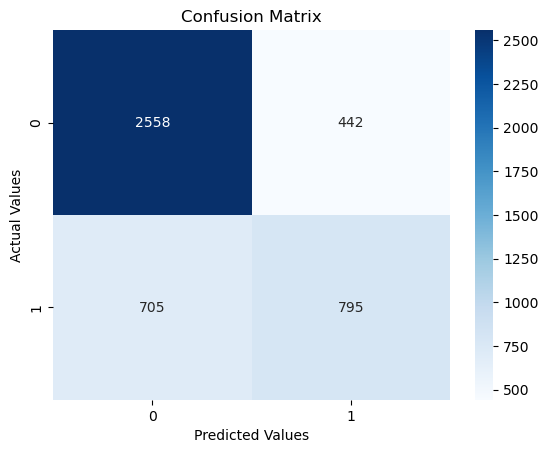

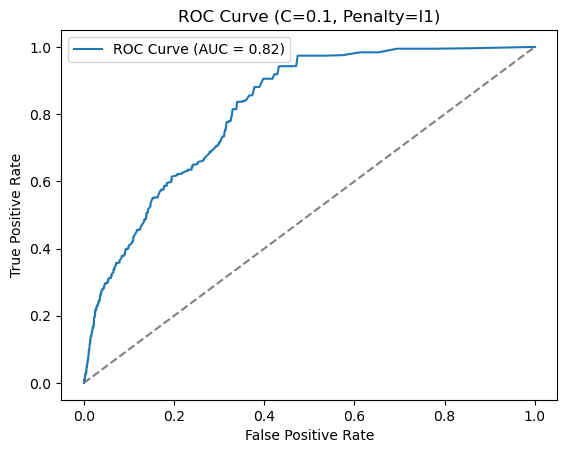

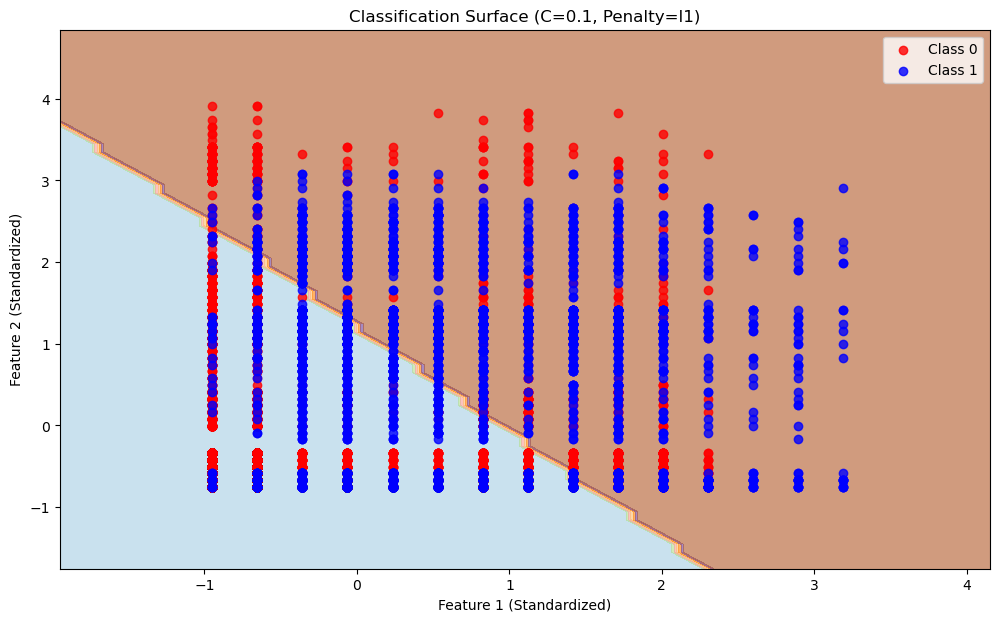

Metryki dla modelu Logistic Regression (C=0.1, Penalty=l2, Class Weight=balanced):
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      3000
           1       0.55      0.71      0.62      1500

    accuracy                           0.71      4500
   macro avg       0.69      0.71      0.69      4500
weighted avg       0.73      0.71      0.71      4500



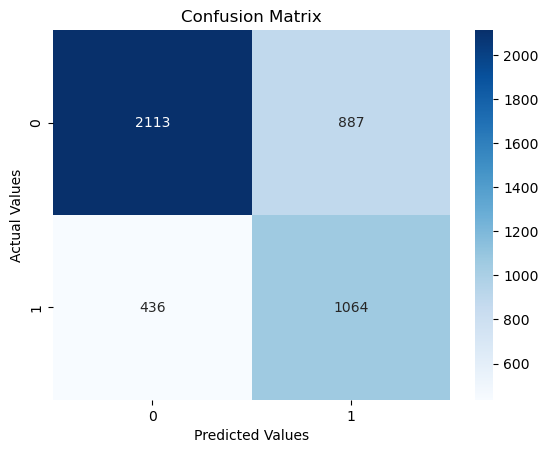

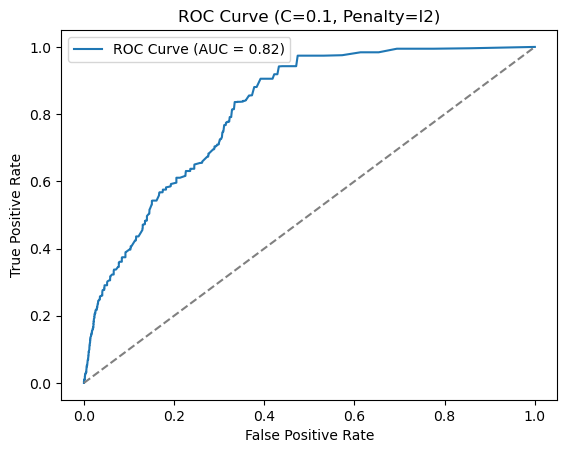

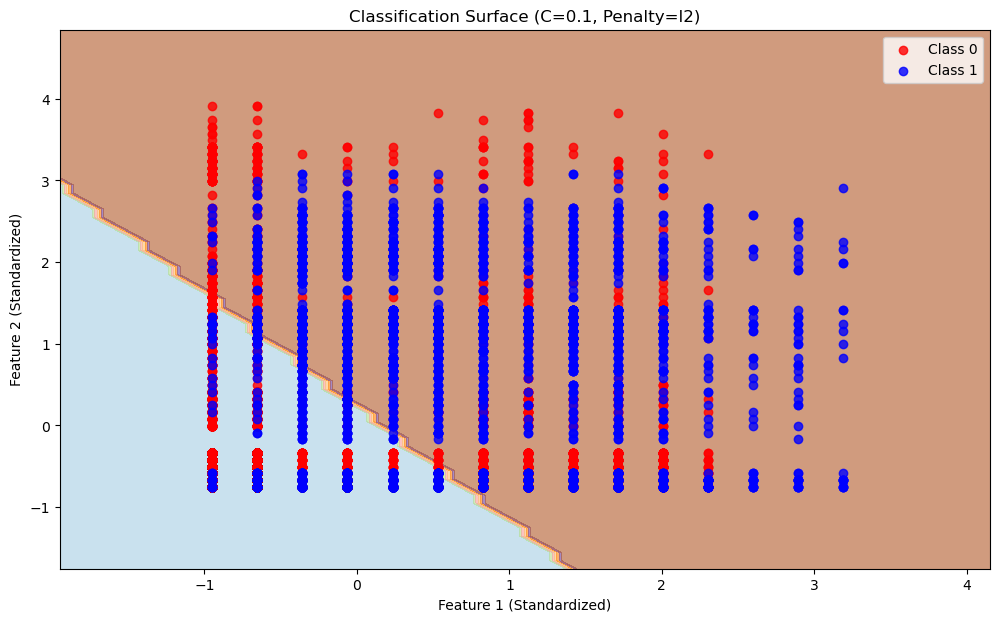

Metryki dla modelu Logistic Regression (C=0.1, Penalty=l2, Class Weight=None):
              precision    recall  f1-score   support

           0       0.78      0.85      0.82      3000
           1       0.64      0.53      0.58      1500

    accuracy                           0.74      4500
   macro avg       0.71      0.69      0.70      4500
weighted avg       0.74      0.74      0.74      4500



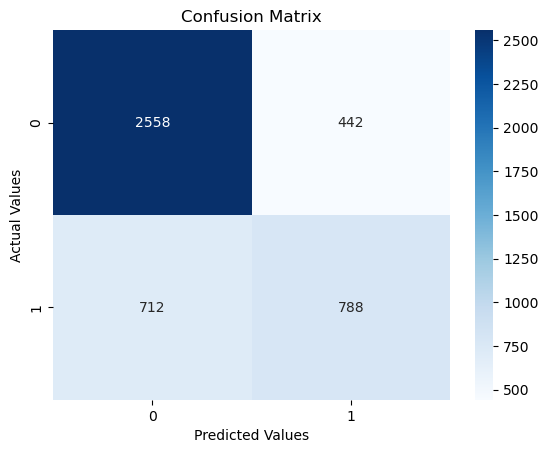

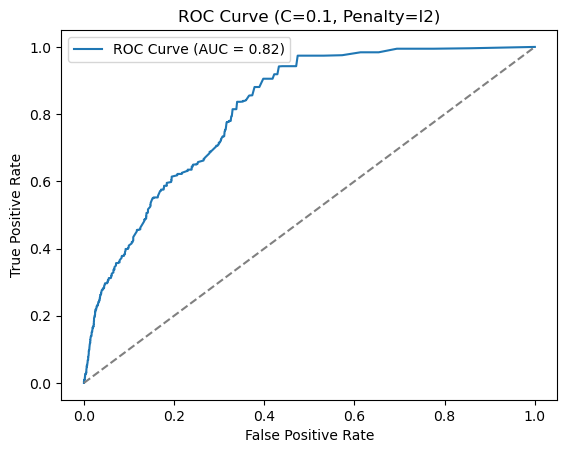

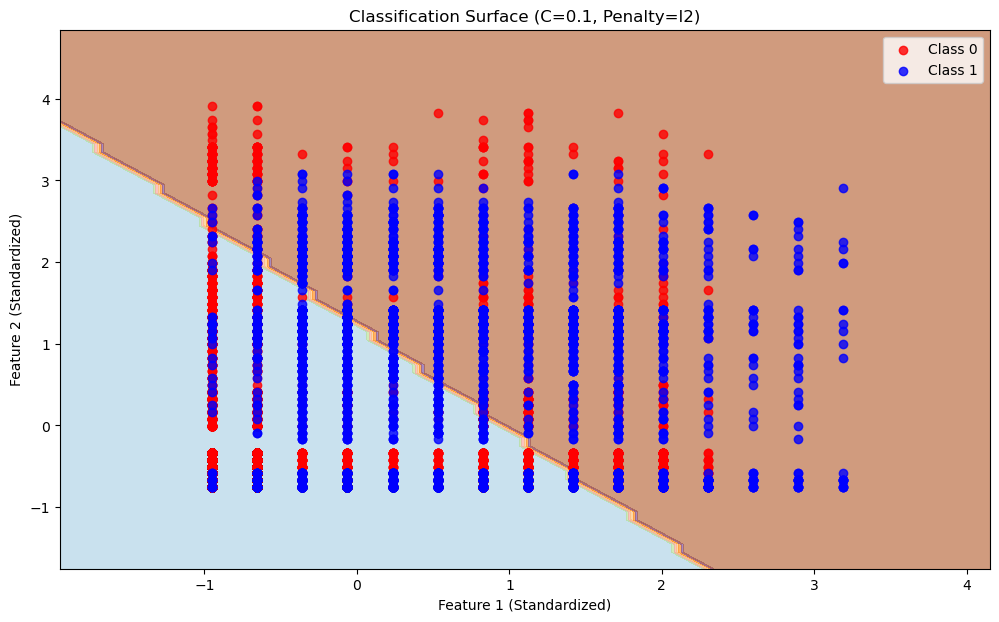

Metryki dla modelu Logistic Regression (C=1, Penalty=l1, Class Weight=balanced):
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      3000
           1       0.55      0.71      0.62      1500

    accuracy                           0.71      4500
   macro avg       0.69      0.71      0.69      4500
weighted avg       0.73      0.71      0.71      4500



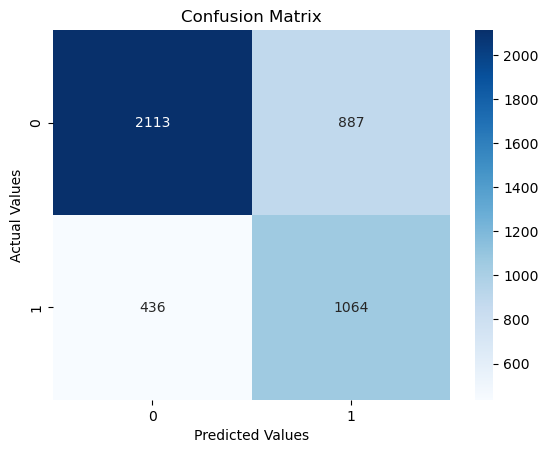

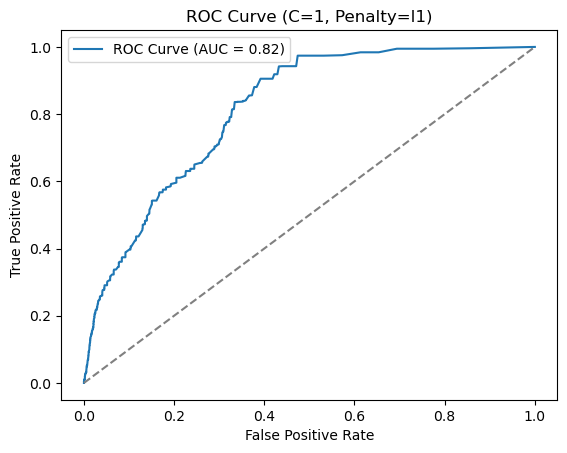

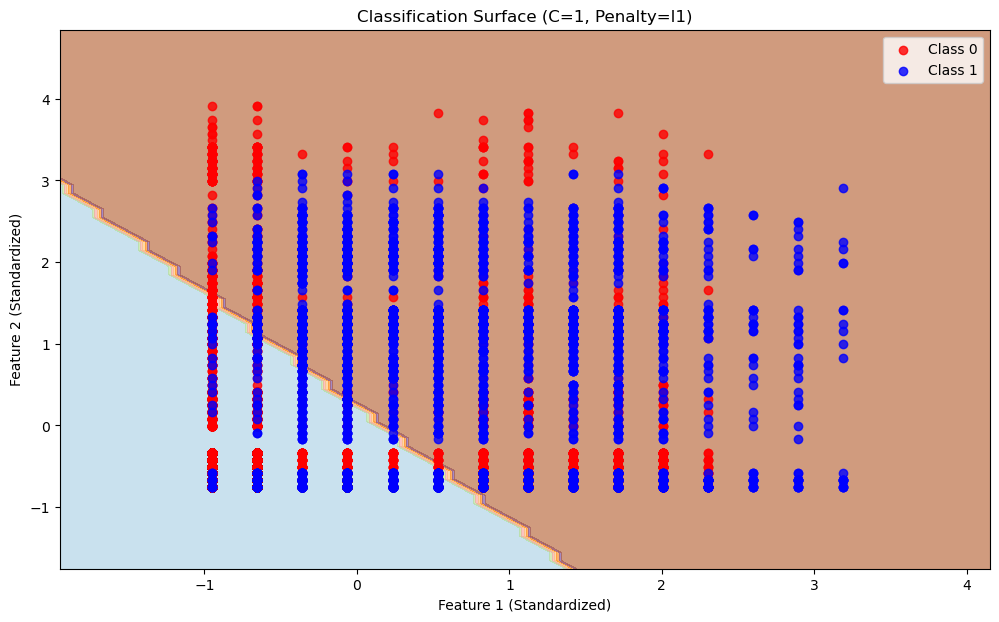

Metryki dla modelu Logistic Regression (C=1, Penalty=l1, Class Weight=None):
              precision    recall  f1-score   support

           0       0.78      0.85      0.82      3000
           1       0.64      0.53      0.58      1500

    accuracy                           0.75      4500
   macro avg       0.71      0.69      0.70      4500
weighted avg       0.74      0.75      0.74      4500



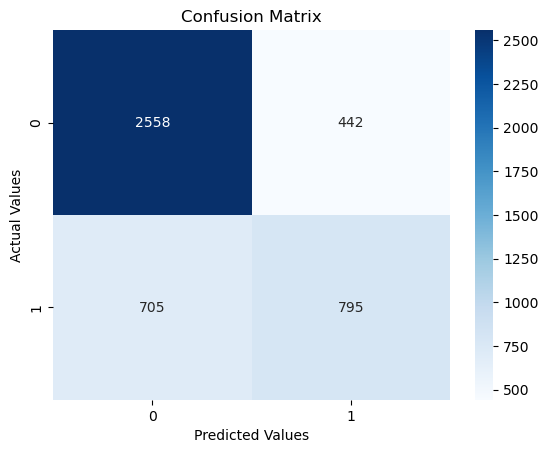

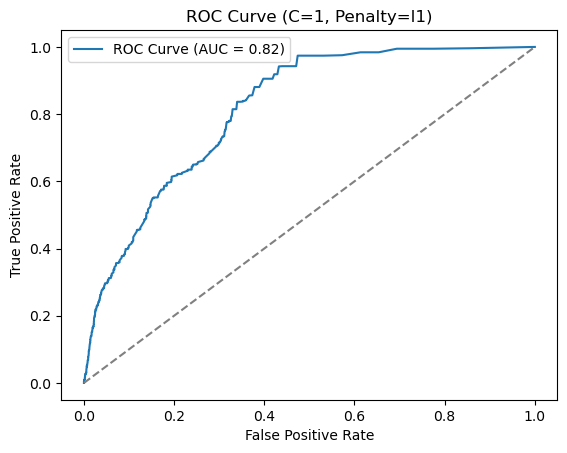

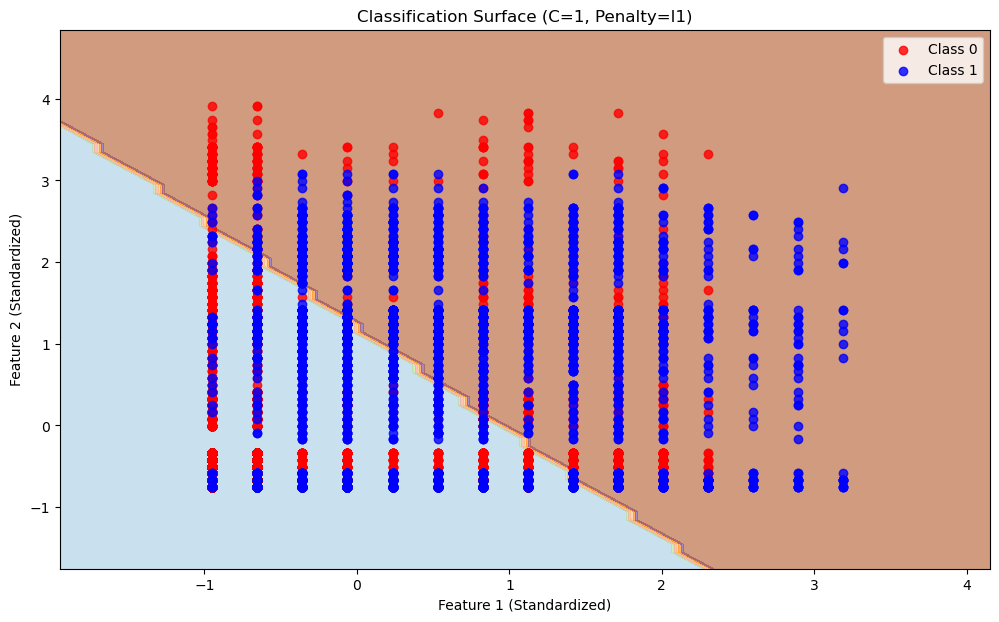

Metryki dla modelu Logistic Regression (C=1, Penalty=l2, Class Weight=balanced):
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      3000
           1       0.55      0.71      0.62      1500

    accuracy                           0.71      4500
   macro avg       0.69      0.71      0.69      4500
weighted avg       0.73      0.71      0.71      4500



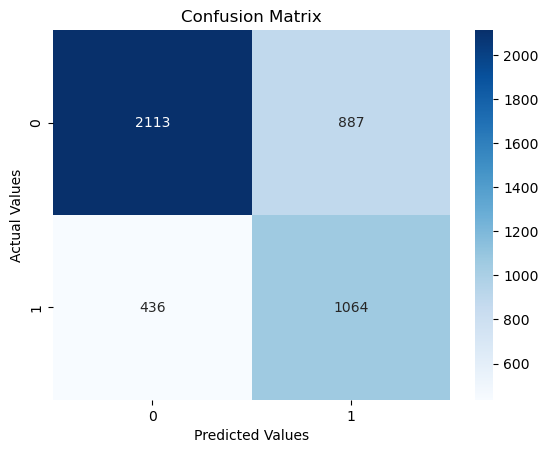

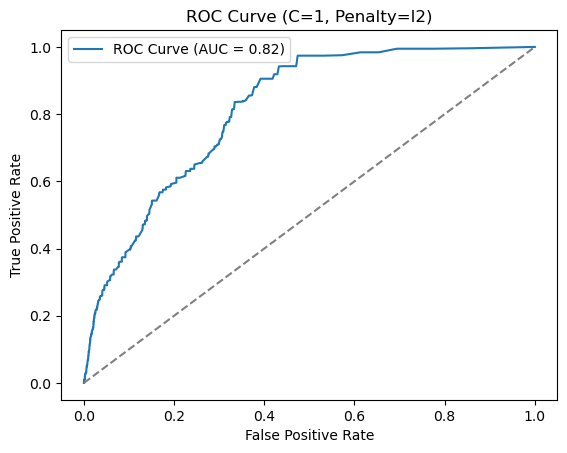

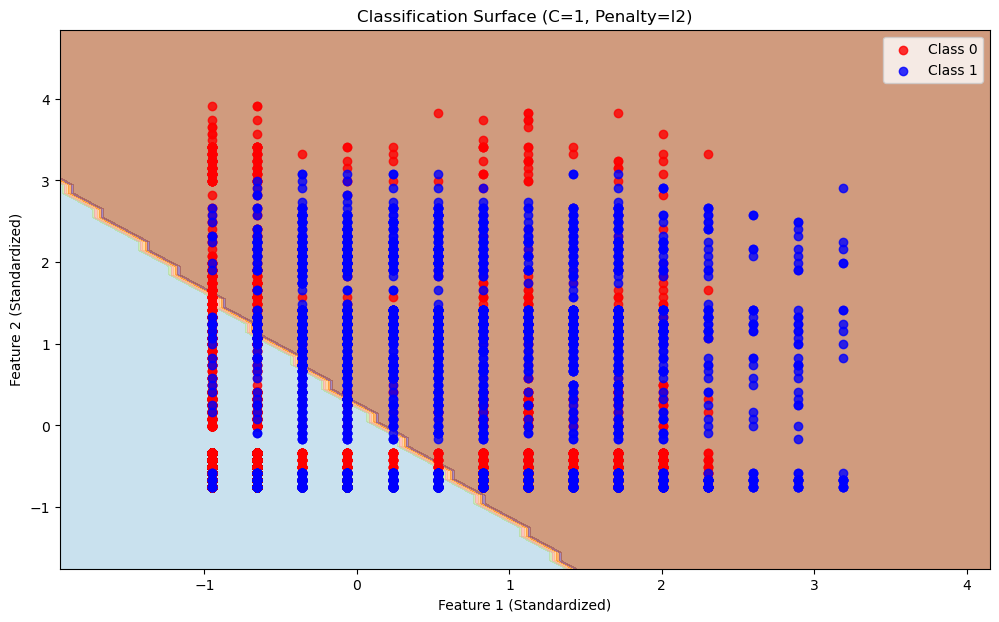

Metryki dla modelu Logistic Regression (C=1, Penalty=l2, Class Weight=None):
              precision    recall  f1-score   support

           0       0.78      0.85      0.82      3000
           1       0.64      0.53      0.58      1500

    accuracy                           0.75      4500
   macro avg       0.71      0.69      0.70      4500
weighted avg       0.74      0.75      0.74      4500



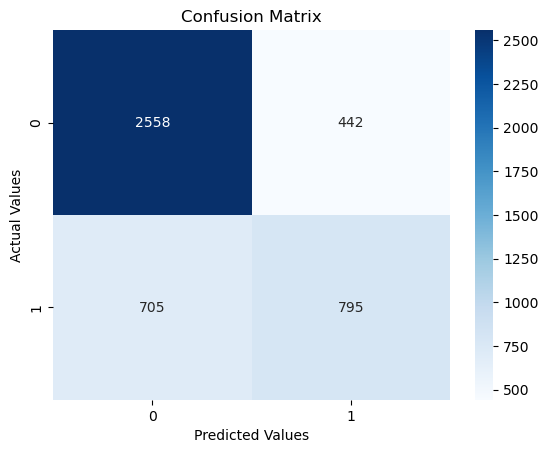

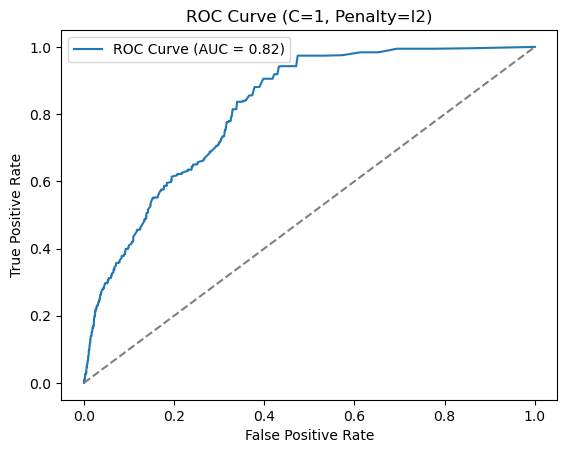

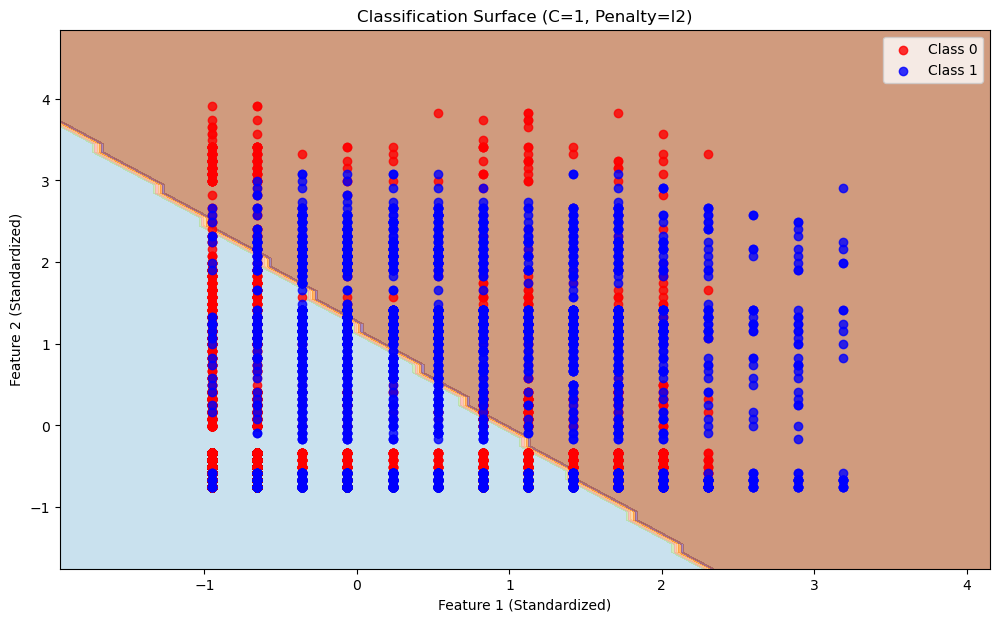

Metryki dla modelu Logistic Regression (C=10, Penalty=l1, Class Weight=balanced):
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      3000
           1       0.55      0.71      0.62      1500

    accuracy                           0.71      4500
   macro avg       0.69      0.71      0.69      4500
weighted avg       0.73      0.71      0.71      4500



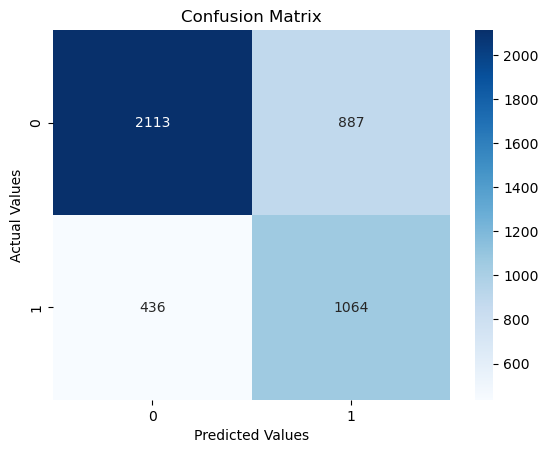

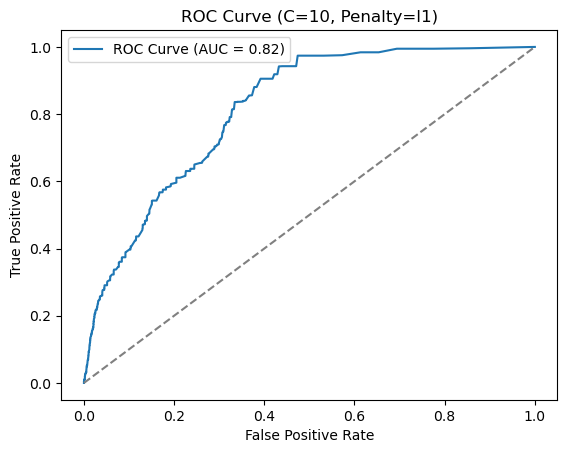

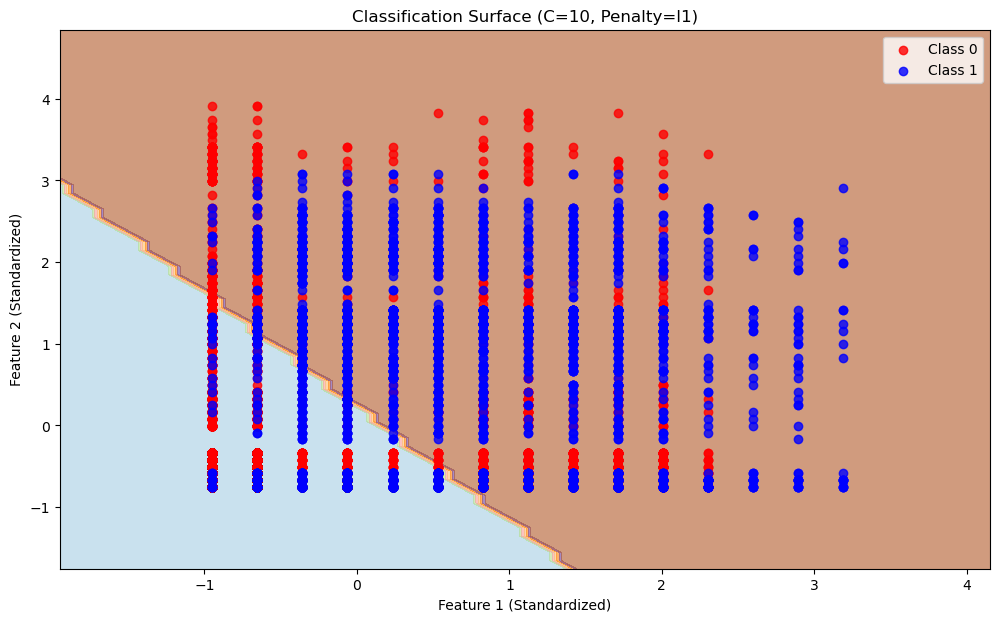

Metryki dla modelu Logistic Regression (C=10, Penalty=l1, Class Weight=None):
              precision    recall  f1-score   support

           0       0.78      0.85      0.82      3000
           1       0.64      0.53      0.58      1500

    accuracy                           0.75      4500
   macro avg       0.71      0.69      0.70      4500
weighted avg       0.74      0.75      0.74      4500



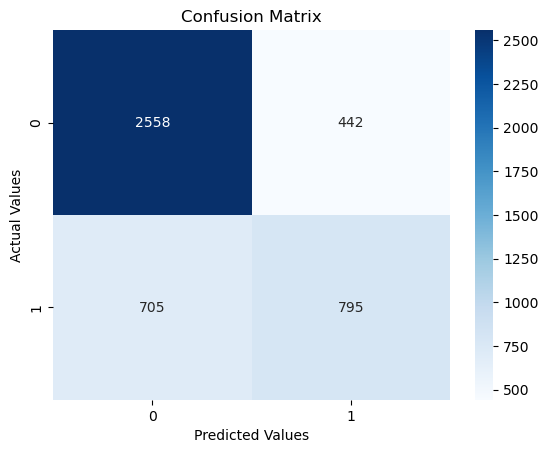

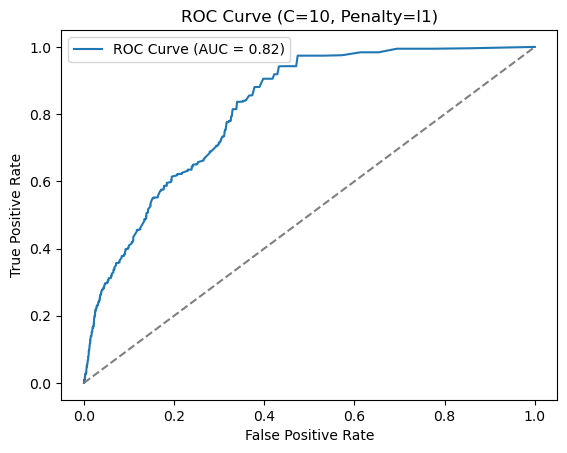

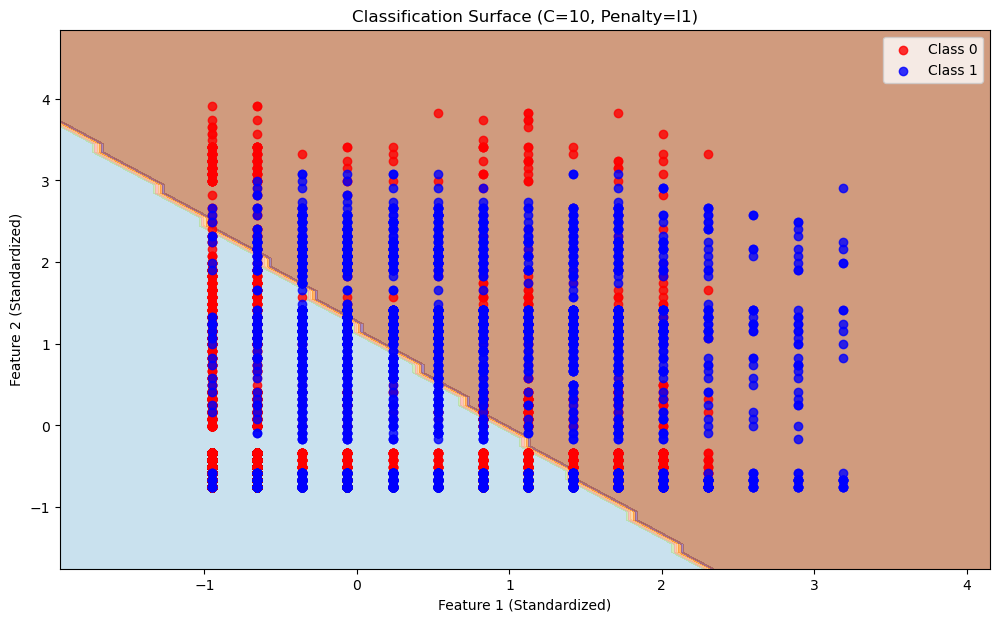

Metryki dla modelu Logistic Regression (C=10, Penalty=l2, Class Weight=balanced):
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      3000
           1       0.55      0.71      0.62      1500

    accuracy                           0.71      4500
   macro avg       0.69      0.71      0.69      4500
weighted avg       0.73      0.71      0.71      4500



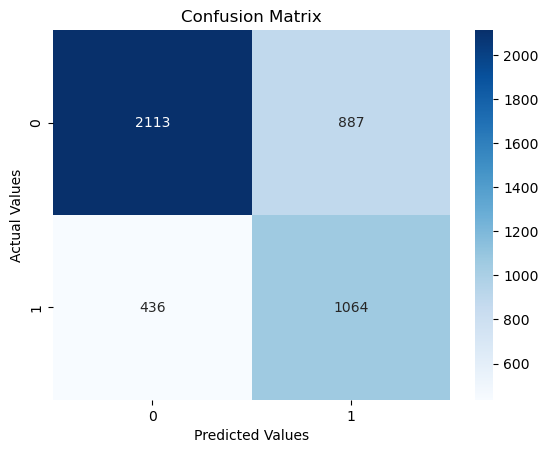

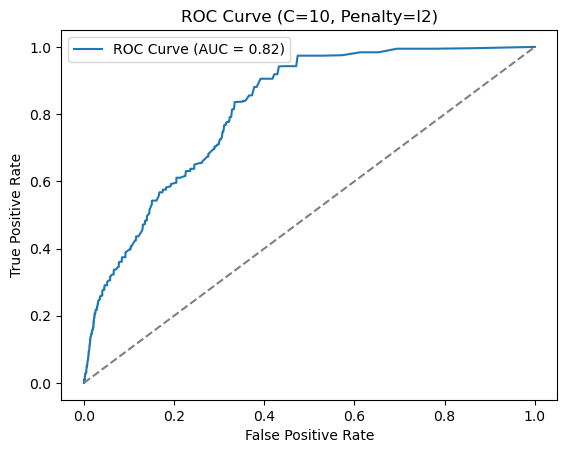

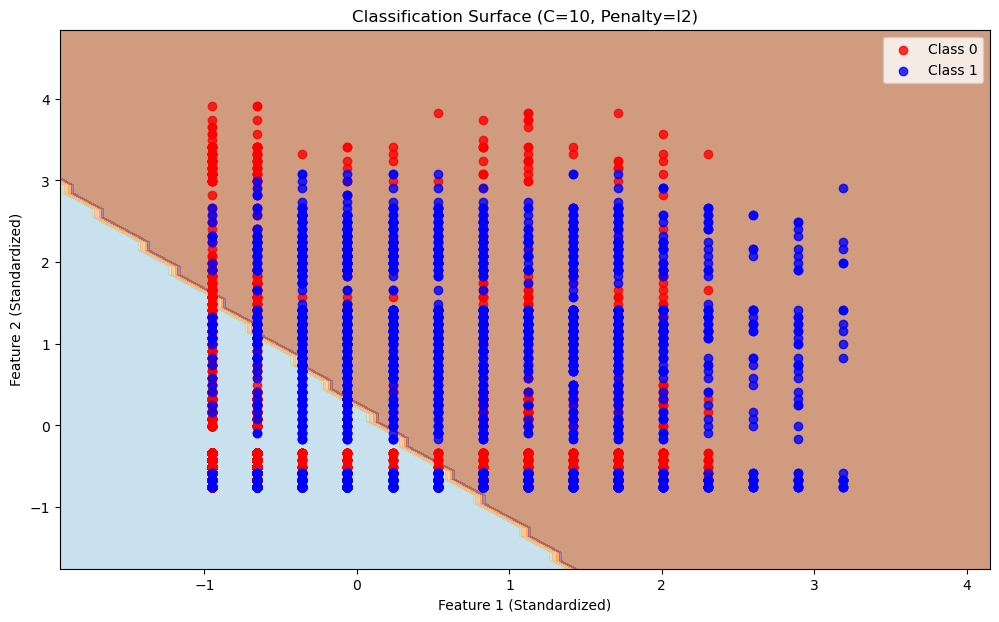

Metryki dla modelu Logistic Regression (C=10, Penalty=l2, Class Weight=None):
              precision    recall  f1-score   support

           0       0.78      0.85      0.82      3000
           1       0.64      0.53      0.58      1500

    accuracy                           0.75      4500
   macro avg       0.71      0.69      0.70      4500
weighted avg       0.74      0.75      0.74      4500



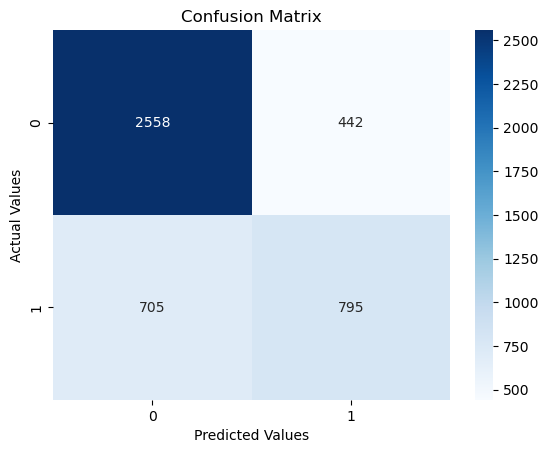

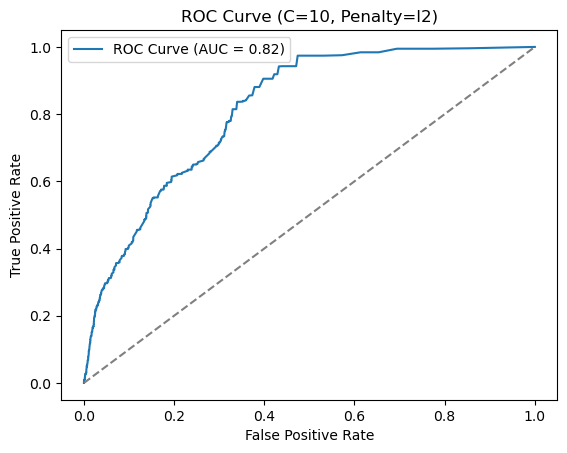

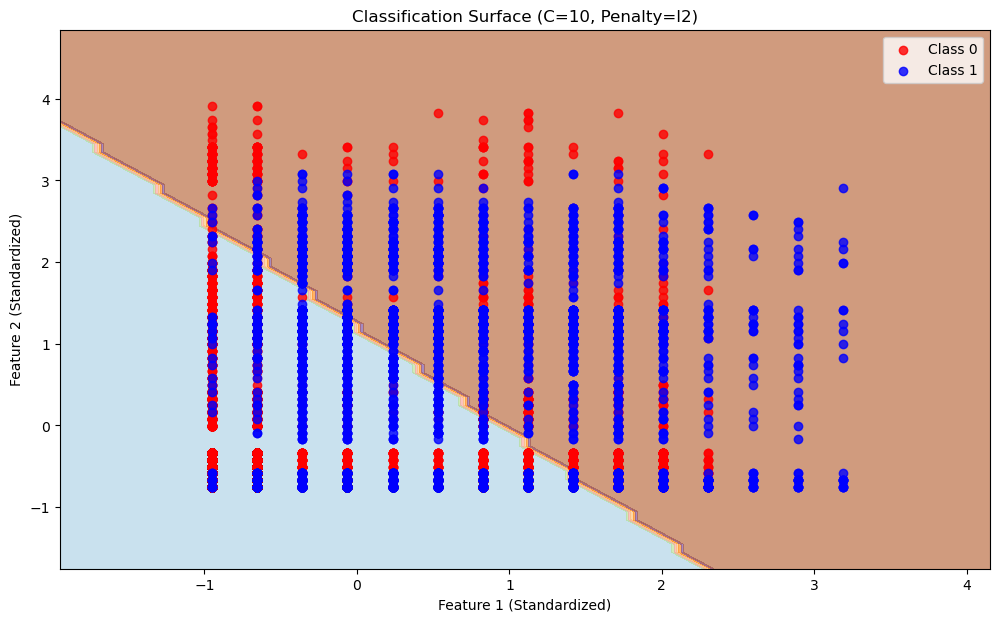

Metryki dla modelu Logistic Regression (C=100, Penalty=l1, Class Weight=balanced):
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      3000
           1       0.55      0.71      0.62      1500

    accuracy                           0.71      4500
   macro avg       0.69      0.71      0.69      4500
weighted avg       0.73      0.71      0.71      4500



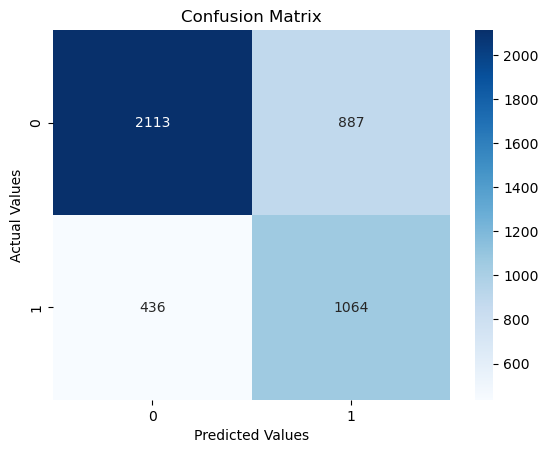

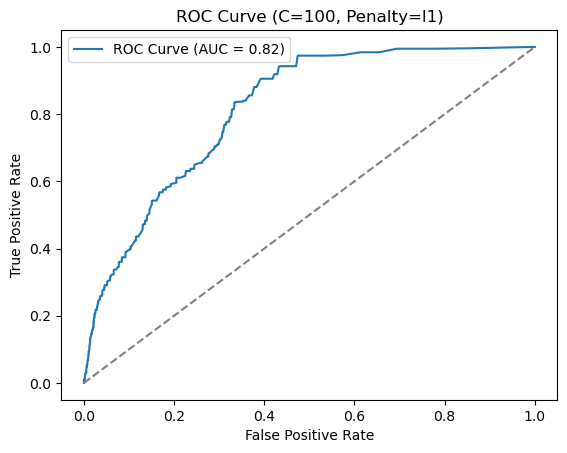

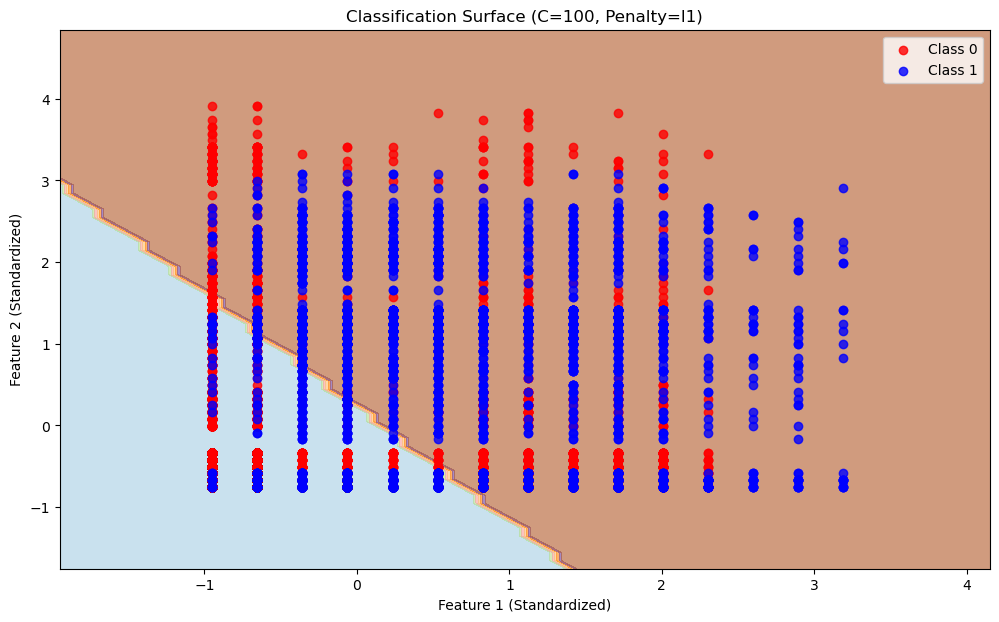

Metryki dla modelu Logistic Regression (C=100, Penalty=l1, Class Weight=None):
              precision    recall  f1-score   support

           0       0.78      0.85      0.82      3000
           1       0.64      0.53      0.58      1500

    accuracy                           0.75      4500
   macro avg       0.71      0.69      0.70      4500
weighted avg       0.74      0.75      0.74      4500



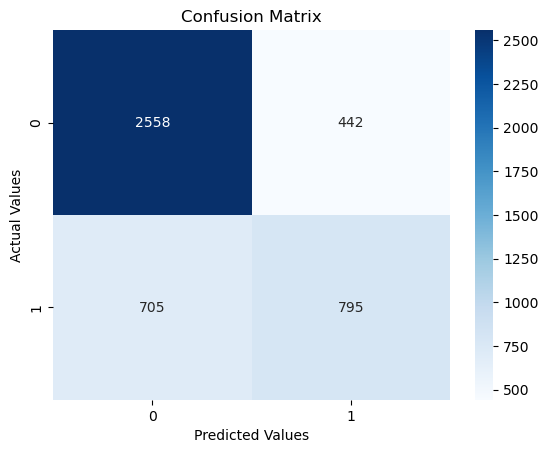

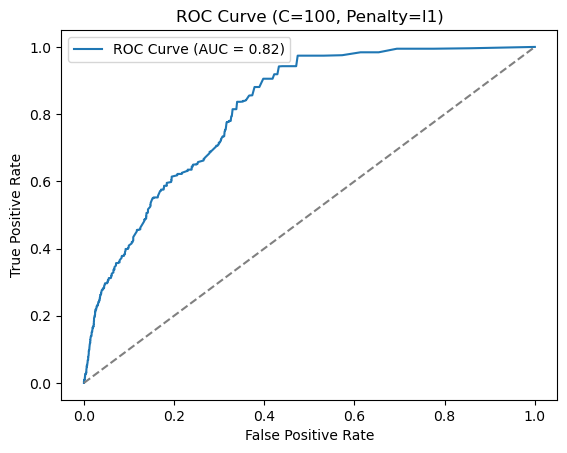

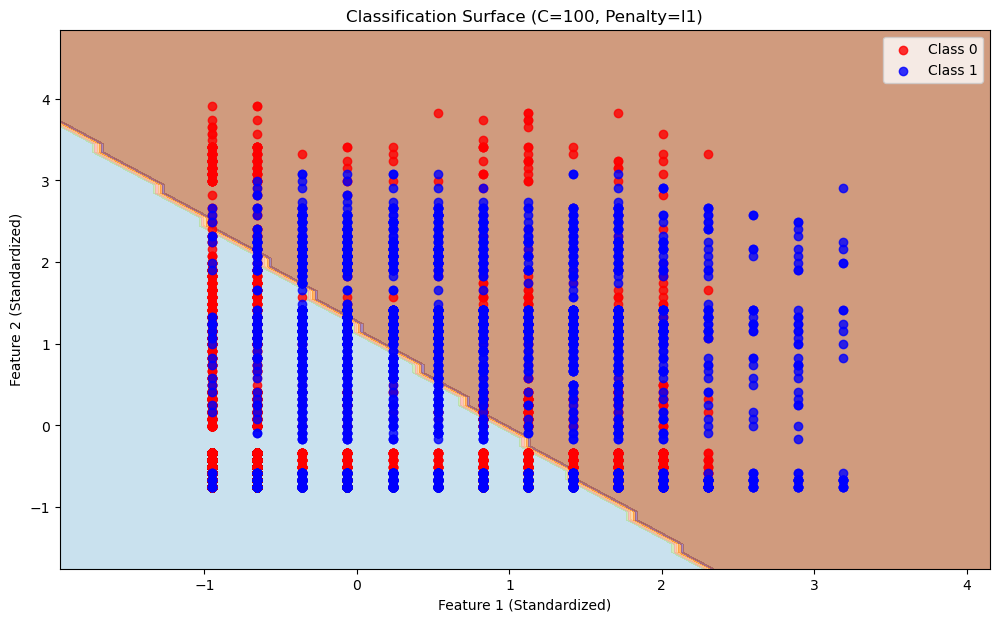

Metryki dla modelu Logistic Regression (C=100, Penalty=l2, Class Weight=balanced):
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      3000
           1       0.55      0.71      0.62      1500

    accuracy                           0.71      4500
   macro avg       0.69      0.71      0.69      4500
weighted avg       0.73      0.71      0.71      4500



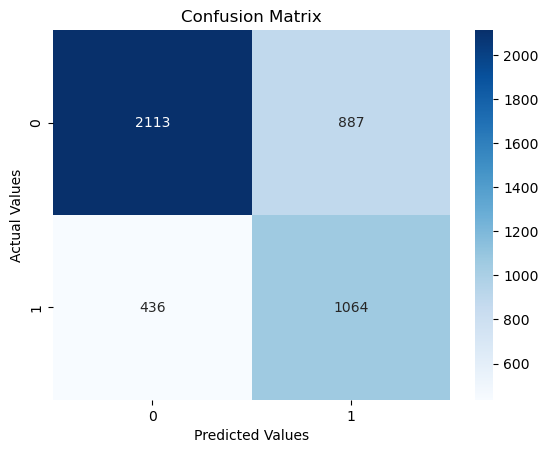

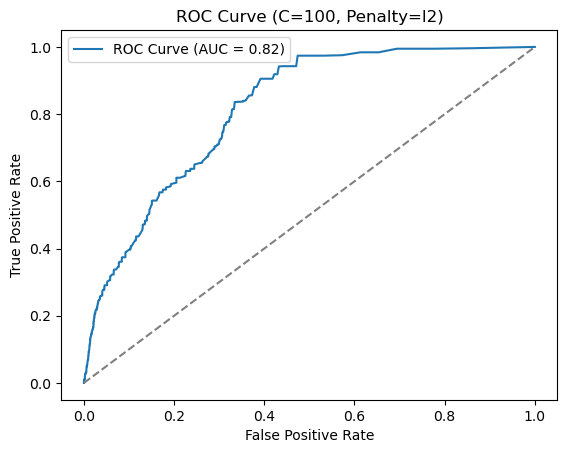

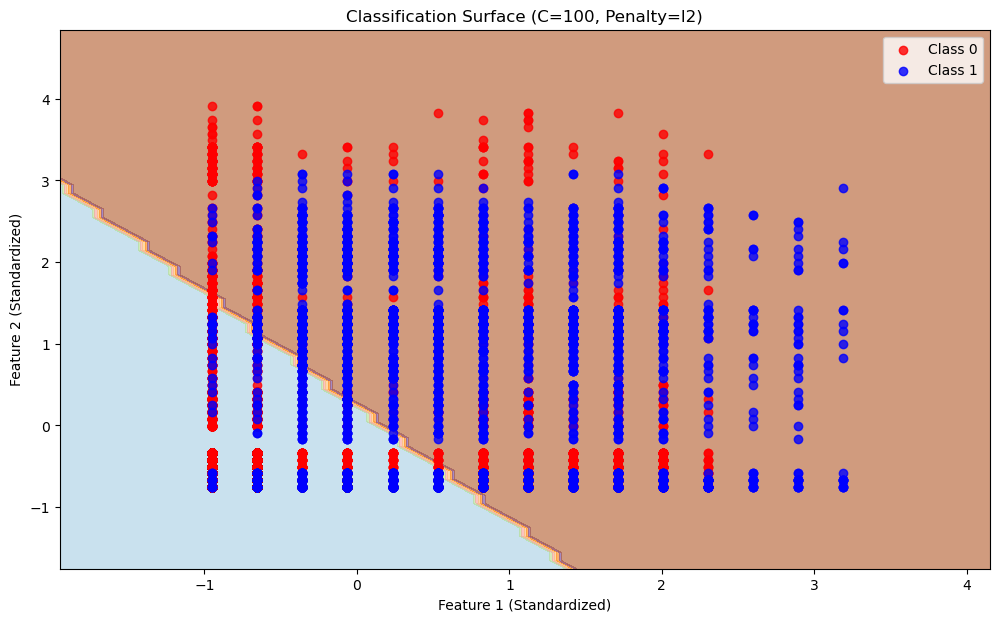

Metryki dla modelu Logistic Regression (C=100, Penalty=l2, Class Weight=None):
              precision    recall  f1-score   support

           0       0.78      0.85      0.82      3000
           1       0.64      0.53      0.58      1500

    accuracy                           0.75      4500
   macro avg       0.71      0.69      0.70      4500
weighted avg       0.74      0.75      0.74      4500



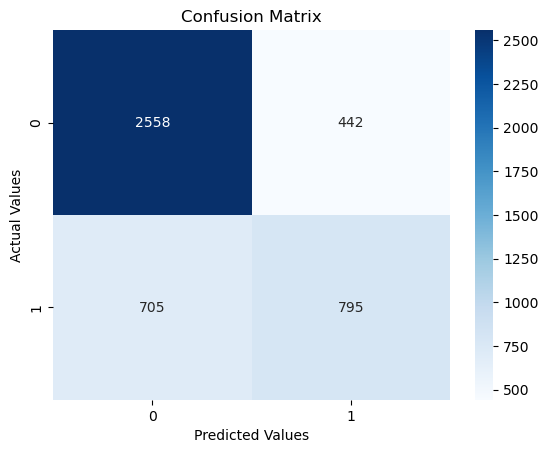

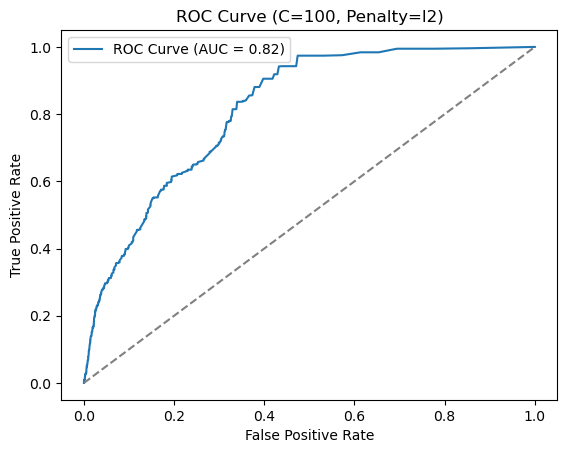

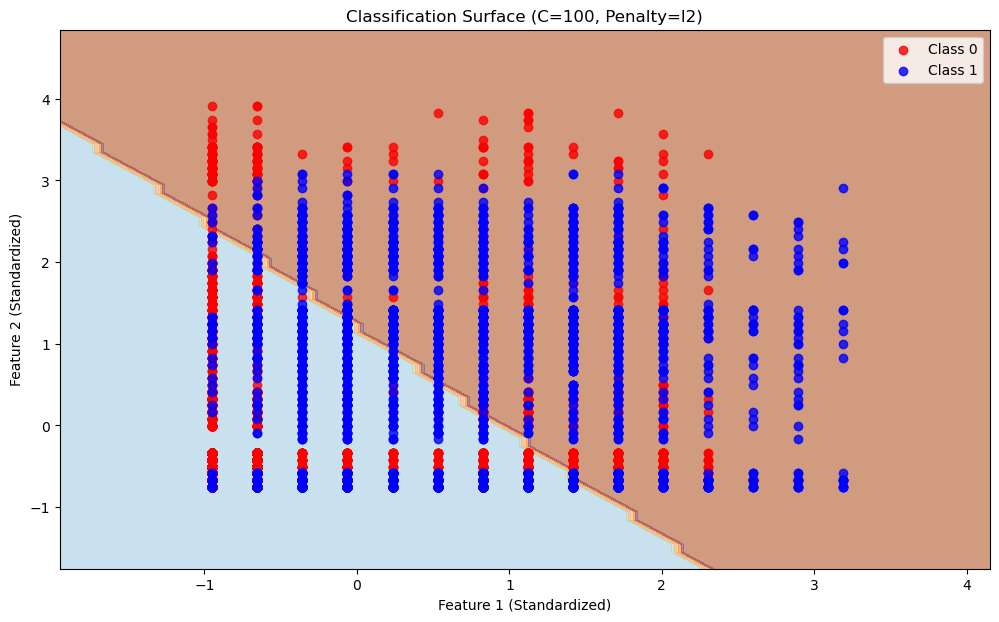

In [10]:
for model_lr, specifics in our_models:
    calculate_metrics(model_lr, 'Logistic Regression', X_test_standardized, y_test, specifics)
    plot_classification_surface(X_train_standardized, y_train, model_lr, specifics)

**#9 Podsumowanie wyników**

In [13]:
print("\nPodsumowanie wyników dla wszystkich modeli:")
print(metrics_dataframe)


Podsumowanie wyników dla wszystkich modeli:
                  Model  F1_score       AUC       C Penalty Class Weight
0   Logistic Regression  0.618497  0.816422    0.01      l1     balanced
1   Logistic Regression  0.577289  0.816045    0.01      l1         None
2   Logistic Regression  0.616411  0.815014    0.01      l2     balanced
3   Logistic Regression  0.567497  0.816493    0.01      l2         None
4   Logistic Regression  0.616633  0.815014    0.10      l1     balanced
5   Logistic Regression  0.580928  0.816494    0.10      l1         None
6   Logistic Regression  0.616633  0.815014    0.10      l2     balanced
7   Logistic Regression  0.577289  0.816493    0.10      l2         None
8   Logistic Regression  0.616633  0.815014    1.00      l1     balanced
9   Logistic Regression  0.580928  0.816493    1.00      l1         None
10  Logistic Regression  0.616633  0.815014    1.00      l2     balanced
11  Logistic Regression  0.580928  0.816493    1.00      l2         None
12  Lo

**#10 Wybranie najlepszego modelu**

In [14]:
best_model = metrics_dataframe.sort_values(by=['F1_score', 'AUC'], ascending=False).iloc[0]
print("Najlepszy model:")
print(best_model)

Najlepszy model:
Model           Logistic Regression
F1_score                   0.618497
AUC                        0.816422
C                              0.01
Penalty                          l1
Class Weight               balanced
Name: 0, dtype: object


**#11 Raport końcowy**

Najlepszy model - regresja logistyczna z następującymi parametrami:
1. (Penalty): L1 – wybiera tylko najistotniejsze cechy, eliminując mniej znaczące, co ogranicza przeuczenie i zwiększa interpretowalność modelu.
2. (C): 0.01 – stosunkowo wysoka regularyzacja, co pozwala modelowi na uproszczenie struktury bez nadmiernego dopasowania do danych treningowych.
3. (Class Weight): "balanced" – automatyczne dostosowanie wag klas, aby uwzględnić nierównowagę w danych (większość próbek należy do jednej klasy).
   
Wyniki:
1. F1-score: 0.6185 – świadczy o dobrej równowadze między precyzją (dokładnością wyników dla klasy pozytywnej) a czułością (wykrywaniem klasy pozytywnej).
2. AUC: 0.8164 – model dobrze rozróżnia klasy, co oznacza, że ma wysoką skuteczność w przewidywaniu zarówno pozytywnych, jak i negatywnych przypadków.

Podsumowując - model jest dobrze dopasowany do danych, skuteczny w klasyfikacji oraz odporny na przeuczenie dzięki odpowiedniej regularyzacji i uwzględnieniu nierównowagi klas. Jest odpowiedni do dalszego zastosowania na podobnych danych.